<a href="https://colab.research.google.com/github/bkvkrll/PyTorch/blob/main/lesson7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech


Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [7]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from string import punctuation

from pymorphy2 import MorphAnalyzer
import re
import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from stop_words import get_stop_words
from tqdm import tqdm 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
max_words = 20000
max_len = 10
num_classes = 1

# обучение
epochs = 10
batch_size = 512
print_batch_n = 100

In [11]:
dataset_train  = '/content/train.csv'
dataset_test  = '/content/test.csv'

In [12]:
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')

In [13]:
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [14]:
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [15]:
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=42)

In [16]:
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [17]:
df_train['label'].value_counts()

0    20815
1     1558
Name: label, dtype: int64

In [18]:
df_valid.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


In [19]:
df_valid['label'].value_counts()

0    8905
1     684
Name: label, dtype: int64

In [20]:
sw = set(get_stop_words("ru"))
puncts = set(punctuation)
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [21]:
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:12<00:00, 1347.46it/s]


In [22]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [23]:
tokens = word_tokenize(train_corpus)
tokens[:10]

['summer',
 'timeð\x9f\x8c',
 'summeriscoming',
 'swimming',
 'picoftheday',
 'tattoos',
 'issho',
 'pulsera',
 'fluyendo',
 'â\x80¦']

In [24]:
tokens_filtered = [word for word in tokens if word.isalnum()]
print(tokens_filtered)

['summer', 'summeriscoming', 'swimming', 'picoftheday', 'tattoos', 'issho', 'pulsera', 'fluyendo', 'dese', 'niggas', 'will', 'show', 'dese', 'otha', 'bitches', 'on', 'fb', 'snap', 'nd', 'twitter', 'more', 'attention', 'then', 'dey', 'do', 'their', 'own', 'girl', 'but', 'true', 'when', 'you', 'are', 'you', 'boost', 'your', 'immune', 'system', 'and', 'allow', 'your', 'bodies', 'to', 'use', 'the', 'energy', 'reading', 'my', 'manuscript', 'and', 'not', 'wanting', 'to', 'stop', 'good', 'evening', 'and', 'good', 'night', 'baby', 'says', 'he', 'hates', 'me', 'today', 'im', 'a', 'dj', 'lol', 'womanofmanyhats', 'instamood', 'love', 'silentdisco', 'christmas', 'eve', 'what', 'about', 'christmas', 'adam', 'this', 'is', 'towards', 'men', 'down', 'with', 'feminism', 'have', 'my', 'lover', 'stop', 'being', 'angry', 'at', 'me', 'visit', 'usgtgtgt', 'lover', 'friend', 'astrologer', 'love', 'best', 'wishes', 'from', 'outside', 'gym', 'fitness', 'macboys', 'blue', 'white', 'grey', 'user', 'stress', 'is'

In [25]:
dist = FreqDist(tokens_filtered)
dist

FreqDist({'summer': 373,
          'summeriscoming': 2,
          'swimming': 24,
          'picoftheday': 47,
          'tattoos': 4,
          'issho': 1,
          'pulsera': 1,
          'fluyendo': 2,
          'dese': 8,
          'niggas': 21,
          'will': 880,
          'show': 188,
          'otha': 1,
          'bitches': 18,
          'on': 1838,
          'fb': 15,
          'snap': 11,
          'nd': 6,
          'twitter': 100,
          'more': 497,
          'attention': 18,
          'then': 198,
          'dey': 5,
          'do': 813,
          'their': 318,
          'own': 116,
          'girl': 237,
          'but': 741,
          'true': 137,
          'when': 895,
          'you': 3726,
          'are': 1317,
          'boost': 4,
          'your': 1193,
          'immune': 2,
          'system': 22,
          'and': 3384,
          'allow': 20,
          'bodies': 4,
          'to': 6758,
          'use': 74,
          'the': 7029,
          'energy': 36,

In [26]:
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(19999, ['user', 'the', 'to', 'a', 'i', 'you', 'and', 'in', 'for', 'of'])

In [27]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top,1)).items()}
vocabulary

{'user': 1,
 'the': 2,
 'to': 3,
 'a': 4,
 'i': 5,
 'you': 6,
 'and': 7,
 'in': 8,
 'for': 9,
 'of': 10,
 'is': 11,
 'my': 12,
 'love': 13,
 'on': 14,
 'this': 15,
 'with': 16,
 'it': 17,
 'be': 18,
 'day': 19,
 'so': 20,
 'all': 21,
 'are': 22,
 'that': 23,
 'me': 24,
 'your': 25,
 'happy': 26,
 'at': 27,
 'have': 28,
 'amp': 29,
 'just': 30,
 'we': 31,
 'its': 32,
 'when': 33,
 'will': 34,
 'not': 35,
 'am': 36,
 'do': 37,
 'u': 38,
 'im': 39,
 'life': 40,
 'time': 41,
 'but': 42,
 'what': 43,
 'from': 44,
 'like': 45,
 'up': 46,
 'today': 47,
 'new': 48,
 'positive': 49,
 'now': 50,
 'thankful': 51,
 'out': 52,
 'as': 53,
 'was': 54,
 'get': 55,
 'our': 56,
 'how': 57,
 'by': 58,
 'good': 59,
 'people': 60,
 'bihday': 61,
 'about': 62,
 'cant': 63,
 'no': 64,
 'one': 65,
 'can': 66,
 'see': 67,
 'fathers': 68,
 'more': 69,
 'they': 70,
 'dont': 71,
 'if': 72,
 'go': 73,
 'smile': 74,
 'want': 75,
 'take': 76,
 'work': 77,
 'who': 78,
 'healthy': 79,
 'has': 80,
 'weekend': 81,
 'got

In [28]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [29]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]], dtype=np.int32)
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["tweet"]], dtype=np.int32)

x_train.shape, x_valid.shape, x_test.shape

((22373, 10), (9589, 10), (17197, 10))

In [30]:
torch.from_numpy(x_train[0])

tensor([   86,  7576,  1209,   678,  4773, 11733, 11734,  7577,     0,     0],
       dtype=torch.int32)

In [31]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [32]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [33]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 10]) tensor([    2,     1,   161,     2,   132,  8225,  6230, 13382, 13383,     0])
torch.Size([512]) tensor(0)


In [34]:
#LSTM
class LSTMFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        lstm_out, ht = self.lstm(x) 
       
       

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]  
        else:
            
            last_tensor = torch.mean(lstm_out[:,:], dim=1)  
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [35]:
model_lstm = LSTMFixedLen(max_words, 128, 128, use_last=False)
print(model_lstm)
print("Parameters:", sum([param.nelement() for param in model_lstm.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(20000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 2824321


In [36]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_lstm.to(device)
device

'cuda'

In [51]:
model_lstm = model_lstm.to(device)
model_lstm.train()
th = 0.5

train_loss_history_lstm = []
test_loss_history_lstm = []


for epoch in range(epochs):  
    model_lstm.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model_lstm.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history_lstm.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(valid_loader):
        test_labels = data[1].to(device)
        test_outputs = model_lstm(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history_lstm.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.021. Acc: 0.989. Test loss: 0.001. Test acc: 0.947
Epoch [2/10]. Step [44/44]. Loss: 0.041. Acc: 0.989. Test loss: 0.001. Test acc: 0.947
Epoch [3/10]. Step [44/44]. Loss: 0.057. Acc: 0.989. Test loss: 1.104. Test acc: 0.947
Epoch [4/10]. Step [44/44]. Loss: 0.033. Acc: 0.990. Test loss: 0.011. Test acc: 0.947
Epoch [5/10]. Step [44/44]. Loss: 0.019. Acc: 0.990. Test loss: 1.155. Test acc: 0.947
Epoch [6/10]. Step [44/44]. Loss: 0.035. Acc: 0.989. Test loss: 0.573. Test acc: 0.947
Epoch [7/10]. Step [44/44]. Loss: 0.046. Acc: 0.990. Test loss: 0.001. Test acc: 0.947
Epoch [8/10]. Step [44/44]. Loss: 0.028. Acc: 0.990. Test loss: 1.278. Test acc: 0.947
Epoch [9/10]. Step [44/44]. Loss: 0.047. Acc: 0.989. Test loss: 0.965. Test acc: 0.947
Epoch [10/10]. Step [44/44]. Loss: 0.014. Acc: 0.989. Test loss: 0.005. Test acc: 0.947
Training is finished!


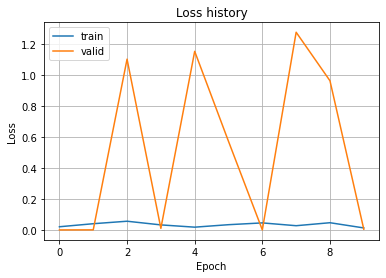

In [52]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history_lstm, label='train')
plt.plot(test_loss_history_lstm, label='valid')
plt.legend()

In [45]:
#GRU
class GRUFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        gru_out, ht = self.gru(x) 
        # gru_out: тензор с выходными фичами с последнего слоя для каждого t #(B, L, Hout)
        # h_t: тензор с последними скрытыми состояниями по слоям  #(num_layers, B, Hout)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]  #(B, Hout) тензор с последней строкой из каждого батча
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)  #(B, Hout) тензор со средним арифметическим столбцов по каждому батчу
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [46]:
model_gru = GRUFixedLen(max_words, 128, 128, use_last=False)
print(model_gru)
print("Parameters:", sum([param.nelement() for param in model_gru.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(20000, 128, padding_idx=0)
  (gru): GRU(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 2758273


In [47]:
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [53]:
model_gru = model_gru.to(device)
model_gru.train()
th = 0.5

train_loss_history_gru = []
test_loss_history_gru = []


for epoch in range(epochs):  
    model_gru.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_gru(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model_gru.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history_gru.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(valid_loader):
        test_labels = data[1].to(device)
        test_outputs = model_lstm(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history_gru.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.063. Acc: 0.980. Test loss: 0.008. Test acc: 0.947
Epoch [2/10]. Step [44/44]. Loss: 0.060. Acc: 0.984. Test loss: 0.001. Test acc: 0.947
Epoch [3/10]. Step [44/44]. Loss: 0.044. Acc: 0.988. Test loss: 0.067. Test acc: 0.947
Epoch [4/10]. Step [44/44]. Loss: 0.021. Acc: 0.989. Test loss: 0.888. Test acc: 0.947
Epoch [5/10]. Step [44/44]. Loss: 0.034. Acc: 0.991. Test loss: 0.002. Test acc: 0.947
Epoch [6/10]. Step [44/44]. Loss: 0.040. Acc: 0.993. Test loss: 1.249. Test acc: 0.947
Epoch [7/10]. Step [44/44]. Loss: 0.016. Acc: 0.994. Test loss: 0.001. Test acc: 0.947
Epoch [8/10]. Step [44/44]. Loss: 0.012. Acc: 0.995. Test loss: 1.847. Test acc: 0.947
Epoch [9/10]. Step [44/44]. Loss: 0.007. Acc: 0.996. Test loss: 0.012. Test acc: 0.947
Epoch [10/10]. Step [44/44]. Loss: 0.025. Acc: 0.997. Test loss: 0.001. Test acc: 0.947
Training is finished!


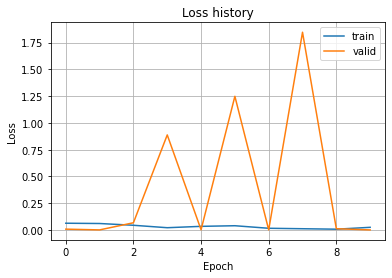

In [54]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history_gru, label='train')
plt.plot(test_loss_history_gru, label='valid')
plt.legend()